## Programming Exercise 4: Neural Networks Learning

#### Setup

In [12]:
import numpy as np
from scipy.io import loadmat
from scipy.optimize import fmin_cg
import matplotlib.pyplot as plt
from IPython.display import Image

data = loadmat('ex4data1.mat')
weights = loadmat('ex4weights.mat')

In [2]:
# Padded with the ones at the beggining
X, y = np.c_[np.ones((data['X'].shape[0],1)), data['X']], data['y'] 
# Showing that the weights contains theta1 and theta2
weights.keys()

['Theta2', '__version__', '__header__', 'Theta1', '__globals__']

In [26]:
print weights['Theta1'].shape, weights['Theta2'].shape

(25, 401) (10, 26)


In [28]:
weights_vector = np.hstack([weights['Theta1'].ravel(), weights['Theta2'].ravel()])
print weights_vector.shape, X.shape

(10285,) (5000, 401)


#### Displaying the Data

In [3]:
def display_data(x):
    im_number = 200
    imv = np.empty((20,0))
    imag = []
    for i in range(im_number):
        im = np.reshape(x[i],(20,20)).T
        imv = np.append(imv,im,axis=1)
        if (i+1) % 20 == 0:
            imag.append(imv)
            imv = np.empty((20,0))
    image = np.concatenate((imag[:]),axis = 0)
    plt.axis('off')
    plt.imshow(image, cmap = 'gray_r')

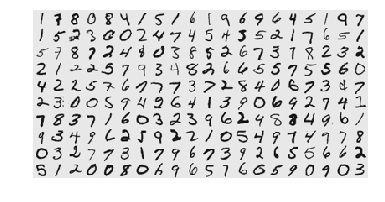

In [4]:
np.random.shuffle(data['X'])
display_data(data['X'])
plt.show()

#### Model Representation
Taken from the assignment's documentation:

![Model](img/Neural_Network_Model.png)

#### Cost Function

##### Gradients

In [5]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def sigmoid_gradient(x):
    return sigmoid(x) * (1 - sigmoid(x))

##### The actual functions

In [88]:
def feed_forward(*args):
    X, theta1, theta2 = args
    
    # FF neural network
    ## Since X is already padded with 1 we don't need to add ones
    a1 = X 
    ## Calculating the Hidden Layer
    a2 = sigmoid(X.dot(theta1.T))
    ## Then adding 1s
    a2 = np.c_[np.ones((a2.shape[0],1)), a2]
    ## Calculating the hypothesis
    h_thx = sigmoid(a2.dot(theta2.T))
    
    return a1, a2, h_thx
    

def calculate_cost(nn_params, num_labels, X, y, reg):
    # Extracting the Thetas
    theta1 = nn_params['Theta1']
    theta2 = nn_params['Theta2']
    
    # Setuping some variables
    m = X.shape[0]
    J = 0
    theta1_grad = np.zeros((theta1.shape))
    theta2_grad = np.zeros((theta2.shape))
    
    # Regularization Function for the Cost
    regfunc = float(reg) / (2. * m) * (np.square(theta1).sum() + np.square(theta2).sum())
    
    # Getting the output from the feedforward
    _, _, h_thx = feed_forward(X, theta1, theta2)
    
    
    # Calculating the Cost Function
    for label in xrange(num_labels):
        y_label = y == label + 1 # since python indexing starts from 0
        h = h_thx[:,label].reshape(-1,1)
        J_label = - 1. / m * (np.log(h).T.dot(y_label) + np.log(1 - h).T.dot(1 - y_label))
        J = J + J_label
        
    return (J + regfunc)

def calculate_grads(nn_params, num_labels, X, y, reg):
    # Extracting the Thetas
    theta1 = nn_params['Theta1']
    theta2 = nn_params['Theta2']
    
    # Setuping some variables
    m = X.shape[0]
    J = 0
    theta1_grad = np.zeros((theta1.shape))
    theta2_grad = np.zeros((theta2.shape))
    
    # Getting Forward Function
    a1, a2, h_thx = feed_forward(X, theta1, theta2)
    
    delta_3 = np.zeros((num_labels, 1))
    delta_2 = np.zeros((theta2.shape[1],1))
    z2 = a1.dot(theta1.T)
    
    # -- for each sample point
    for t in xrange(m):
        for label in xrange(num_labels):
            y_label = y[t,:] == label + 1
            delta_3[label,:] = h_thx[t, label] - y_label
            
        delta_2 = theta2.T.dot(delta_3) * sigmoid_gradient(np.insert(z2[t,:], 0, 1.)).reshape(-1,1)
        # Removing the first delta_2 value as it is to connected to +1
        delta_2 = delta_2[1:,:]
        
        theta1_grad = theta1_grad + delta_2.dot(a1[t,:].reshape(-1,1).T)
        theta2_grad = theta2_grad + delta_3.dot(a2[t,:].reshape(-1,1).T)
        
    
    
    theta1_grad = theta1_grad / m
    theta2_grad = theta2_grad / m
    
    theta1_grad[:,1:] = theta1_grad[:,1:] + reg / m * sum(theta1_grad[:,1:])
    theta2_grad[:,1:] = theta2_grad[:,1:] + reg / m * sum(theta2_grad[:,1:])
    
        
    grad = {
        'Theta1': theta1_grad,
        'Theta2': theta2_grad
    }
    
    
    return grad

##### Testing

In [89]:
# Cost Function with Lambda = 0
cost_0 = calculate_cost(weights, 10, X, y, 0)
print "Should be about 0.287629: %f" % (cost_0)
# Cost Function with Lambda = 1; Should be equal to 0.383770
cost_1 = calculate_cost(weights, 10, X, y, 1)
print "Should be about 0.383770: %f" % (cost_1)

# Testing Sigmoid Gradient
tst = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoid_gradient(tst)
print "Sigmoid Gradient. The 3rd value should be 0.25: " + str(g)

Should be about 0.287629: 0.287629
Should be about 0.383770: 0.384488
Sigmoid Gradient. The 3rd value should be 0.25: [ 0.19661193  0.23500371  0.25        0.23500371  0.19661193]


##### Second implementation of the same functions, this time with theta combination
It seems that fmin_cg doesn't like my implementation - thus a new one is needed.

In [90]:
def calculate_cost_wg(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, reg):
    '''
    wg - stands for whole gradient :)
    '''
    # Unrolling the Thetas
    #theta1 = nn_params[:(input_layer_size + 1) * hidden_layer_size].reshape(hidden_layer_size, (input_layer_size + 1))
    #theta2 = nn_params[(input_layer_size + 1) * hidden_layer_size:].reshape(num_labels, (hidden_layer_size + 1))
    
    theta1, theta2 = np.split(nn_params, [(input_layer_size + 1) * hidden_layer_size])
    theta1 = np.reshape(theta1, (hidden_layer_size, (input_layer_size + 1)))
    theta2 = np.reshape(theta2, (num_labels, (hidden_layer_size + 1)))
    # Setuping some variables
    m = X.shape[0]
    J = 0
    theta1_grad = np.zeros((theta1.shape))
    theta2_grad = np.zeros((theta2.shape))
    
    # Regularization Function for the Cost
    regfunc = float(reg) / (2. * m) * (np.square(theta1).sum() + np.square(theta2).sum())
    
    # Getting the output from the feedforward
    _, _, h_thx = feed_forward(X, theta1, theta2)
    
    
    # Calculating the Cost Function
    for label in xrange(num_labels):
        y_label = y == label + 1 # since python indexing starts from 0
        h = h_thx[:,label].reshape(-1,1)
        J_label = - 1. / m * (np.log(h).T.dot(y_label) + np.log(1 - h).T.dot(1 - y_label))
        J = J + J_label
        
    return J + regfunc

def calculate_grads_wg(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, reg):
    # Extracting the Thetas
    # theta1 = nn_params[:(input_layer_size + 1) * hidden_layer_size].reshape(hidden_layer_size, (input_layer_size + 1))
    # theta2 = nn_params[(input_layer_size + 1) * hidden_layer_size:].reshape(num_labels, (hidden_layer_size + 1))
    
    theta1, theta2 = np.split(nn_params, [(input_layer_size + 1) * hidden_layer_size])
    theta1 = np.reshape(theta1, (hidden_layer_size, (input_layer_size + 1)))
    theta2 = np.reshape(theta2, (num_labels, (hidden_layer_size + 1)))    
    
    # Setuping some variables
    m = X.shape[0]
    J = 0
    theta1_grad = np.zeros((theta1.shape))
    theta2_grad = np.zeros((theta2.shape))
    
    # Getting Forward Function
    a1, a2, h_thx = feed_forward(X, theta1, theta2)
    
    delta_3 = np.zeros((num_labels, 1))
    delta_2 = np.zeros((theta2.shape[1],1))
    z2 = a1.dot(theta1.T)
    
    # -- for each sample point
    for t in xrange(m):
        for label in xrange(num_labels):
            y_label = y[t,:] == label + 1
            delta_3[label,:] = h_thx[t, label] - y_label
            
        delta_2 = theta2.T.dot(delta_3) * sigmoid_gradient(np.insert(z2[t,:], 0, 1.)).reshape(-1,1)
        # Removing the first delta_2 value as it is to connected to +1
        delta_2 = delta_2[1:,:]
        
        theta1_grad = theta1_grad + delta_2.dot(a1[t,:].reshape(-1,1).T)
        theta2_grad = theta2_grad + delta_3.dot(a2[t,:].reshape(-1,1).T)
        
    
    
    theta1_grad = theta1_grad / m
    theta2_grad = theta2_grad / m
    
    theta1_grad[:,1:] = theta1_grad[:,1:] + reg / m * sum(theta1_grad[:,1:])
    theta2_grad[:,1:] = theta2_grad[:,1:] + reg / m * sum(theta2_grad[:,1:])
    
    
    return np.hstack([theta1_grad.ravel(), theta2_grad.ravel()])

In [91]:
# Cost Function with Lambda = 0
cost_0 = calculate_cost_wg(weights_vector, 400, 25, 10, X, y, 0)
print "Should be about 0.287629: %f" % (cost_0)
# Cost Function with Lambda = 1; Should be equal to 0.383770
cost_1 = calculate_cost_wg(weights_vector, 400, 25, 10, X, y, 1)
print "Should be about 0.383770: %f" % (cost_1)

Should be about 0.287629: 0.287629
Should be about 0.383770: 0.384488


#### Random Initialization
Selecting values uniformly in the range [-0.12, 0.12]

In [92]:
def rand_init_weights(l_in, l_out, num_labels):
    w_hidden_layer = np.random.uniform(0,1,(l_out, l_in + 1)) * 2 * 0.12 - 0.12
    w_output = np.random.uniform(0,1,(num_labels, w_hidden_layer.shape[0] + 1)) * 2 * 0.12 - 0.12
    
    # Combining to be consistent with the input of the nn cost function
    return {
        'Theta1':w_hidden_layer,
        'Theta2':w_output
    }

def rand_init_weights_wg(l_in, l_out, num_labels):
    w_hidden_layer = np.random.uniform(0,1,(l_out, l_in + 1)) * 2 * 0.12 - 0.12
    w_output = np.random.uniform(0,1,(num_labels, w_hidden_layer.shape[0] + 1)) * 2 * 0.12 - 0.12
        
    # Combining to be consistent with the input of the nn cost function
    return np.hstack([w_hidden_layer.ravel(), w_output.ravel()])

##### Initial Thetas

In [93]:
initial_weights = rand_init_weights(400, 25, 10)
initial_weights_cmb = rand_init_weights_wg(400, 25,10)

#### Checking the Numerical Gradients

In [94]:
def calc_num_grad(J, theta):
    
    # Extracting the thetas
    theta1 = theta['Theta1']
    theta2 = theta['Theta2']
    
    numgrad1 = np.zeros(theta1.shape)
    perturb1 = np.zeros(theta1.shape)
    numgrad2 = np.zeros(theta2.shape)
    perturb2 = np.zeros(theta2.shape)
    
    e = 0.0001

    for p1 in xrange(0, theta1.shape[1]):
        for p2 in xrange(0, theta1.shape[0]):
            perturb1[p2, p1] = e
            loss1 = J({'Theta1':(theta1 - perturb1), 'Theta2':theta2})
            loss2 = J({'Theta1':(theta1 + perturb1), 'Theta2':theta2})

            numgrad1[p2, p1] = (loss2 - loss1) / (2*e)
            perturb1[p2, p1] = 0
            
    for p1 in xrange(0, theta2.shape[1]):
        for p2 in xrange(0, theta2.shape[0]):
            perturb2[p2, p1] = e
            loss1 = J({'Theta1': theta1, 'Theta2':(theta2 - perturb2)})
            loss2 = J({'Theta1': theta1, 'Theta2':(theta2 + perturb2)})

            numgrad2[p2, p1] = (loss2 - loss1) / (2*e)
            perturb2[p2, p1] = 0
        
    return {'Theta1': numgrad1, 'Theta2': numgrad2}

def gradient_check(reg):
    # Define the initial parameters for the test
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    
    # Initializing Theta
    initial_grad = rand_init_weights(input_layer_size, hidden_layer_size, num_labels)
    theta1 = initial_grad['Theta1']
    theta2 = initial_grad['Theta2']
    
    # Generating X
    X = np.random.rand(m, input_layer_size)
    # Padding X with ones
    X = np.c_[np.ones((X.shape[0],1)), X]
    # Generating Y
    y = np.array([np.mod(i,num_labels) + 1 for i in xrange(1,m + 1)]).reshape(-1,1)
    
    # Calculating the resulting gradient
    grad = calculate_grads(initial_grad, num_labels, X, y, reg)
    
    num_grad = calc_num_grad(lambda theta: calculate_cost(theta, num_labels, X, y, reg), initial_grad)


    flat_grad = np.hstack([grad['Theta1'].ravel(), grad['Theta2'].ravel()])
    flat_num_grad = np.hstack([num_grad['Theta1'].ravel(), num_grad['Theta2'].ravel()])
    
    print 'Calculated Gradient, Numerical Gradient'
    for i in range(len(flat_grad)):
        print (flat_grad[i], flat_num_grad[i]) 
    
    print 
    diff = np.linalg.norm(flat_num_grad - flat_grad) / np.linalg.norm(flat_num_grad + flat_grad)
    print 'Relative Difference: '
    print diff

In [95]:
gradient_check(0)

Calculated Gradient, Numerical Gradient
(-0.0075494021586832117, -0.0075494021523070387)
(-0.0067215210667179882, -0.0067215210641791145)
(-0.0026438016611456854, -0.0026438016598184788)
(0.00031948467465298374, 0.00031948467427156402)
(-0.0092864225987117112, -0.0092864225931243993)
(-0.0048054700554322639, -0.0048054700529931438)
(-0.004135120999912127, -0.0041351209989493043)
(-0.0027104457259695802, -0.0027104457256399428)
(-0.0051843169909198666, -0.0051843169868170946)
(0.0011706348888026071, 0.0011706348868045779)
(-0.0038579446463099867, -0.0038579446415276664)
(-0.0015896620956999973, -0.0015896620975119902)
(-0.0088739303060477795, -0.00887393030168937)
(-0.0060094222130980509, -0.0060094222087414551)
(-0.003276588586692259, -0.0032765885848995424)
(-0.0031840399646461499, -0.0031840399650207019)
(0.0018702792962690569, 0.0018702792936586832)
(-0.0030929962170114025, -0.0030929962147041579)
(0.0025203492700281512, 0.0025203492692860152)
(0.00030791190903838375, 0.000307911909

The relative difference above should be smaller than 1e-9

#### Learning parameters using fmincg

In [62]:
print initial_weights_cmb.shape

(10285,)


In [120]:
# Theta has been initialized above
reg = 1
max_iter = 30
labels = 10
hls = 25 # Hidden Layer Size
ils = 400 # Input Layer Size

calc_weights = fmin_cg(calculate_cost_wg, initial_weights_cmb, fprime=calculate_grads_wg, args=(ils, hls, labels, X,y, reg), maxiter = max_iter, disp=1)

         Current function value: 0.555239
         Iterations: 30
         Function evaluations: 72
         Gradient evaluations: 72


#### Prediction

In [121]:
def predict(theta, X, *args):
    
    input_layer_size, hidden_layer_size, num_labels = args
    # Unrolling the thetas
    theta1, theta2 = np.split(theta, [(input_layer_size + 1) * hidden_layer_size])
    theta1 = np.reshape(theta1, (hidden_layer_size, (input_layer_size + 1)))
    theta2 = np.reshape(theta2, (num_labels, (hidden_layer_size + 1)))    
    
    _, _, htxh = feed_forward(X, theta1, theta2)
    
    return np.argmax(htxh, axis=1).reshape(-1,1)

def accurate(prediction, y):
    return sum(prediction == y%10) / float(y.shape[0])*100

In [122]:
predictions = predict(calc_weights, X, ils, hls, labels)
accuracy = accurate(predictions, y)

In [123]:
print accuracy

[ 0.5]
